In [1]:
# ============================================
# Section 2.1 – Dataset Description and Analysis
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
# Load the Ames Housing dataset
df = pd.read_csv("AmesHousing.csv")

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,NaN,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
# Overview of data types and missing values
print("\n--- Data Info ---")
df.info()

print("\n--- Missing Values ---")
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing.head(10)


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 


Pool QC          2917
Misc Feature     2824
Alley            2732
Fence            2358
Mas Vnr Type     1775
Fireplace Qu     1422
Lot Frontage      490
Garage Cond       159
Garage Qual       159
Garage Finish     159
dtype: int64

In [4]:
# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

Numeric features: 39
Categorical features: 43



Target Summary:
count      2930.000000
mean     180796.060068
std       79886.692357
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64


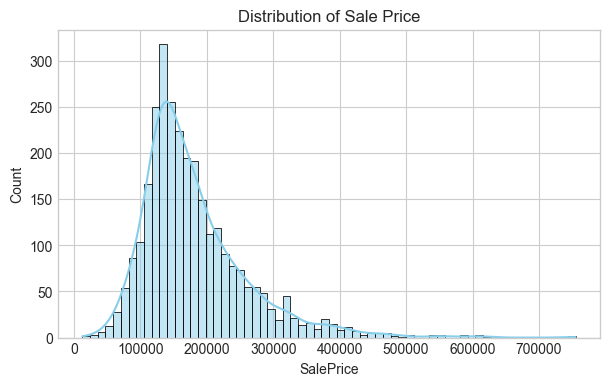

Skewness: 1.7435000757376466


In [5]:
target = "SalePrice"
print("\nTarget Summary:")
print(df[target].describe())

plt.figure(figsize=(7,4))
sns.histplot(df[target], kde=True, color='skyblue')
plt.title("Distribution of Sale Price")
plt.show()

print("Skewness:", df[target].skew())


Top 10 Correlated Features with SalePrice:
SalePrice         1.000000
Overall Qual      0.799262
Gr Liv Area       0.706780
Garage Cars       0.647877
Garage Area       0.640401
Total Bsmt SF     0.632280
1st Flr SF        0.621676
Year Built        0.558426
Full Bath         0.545604
Year Remod/Add    0.532974
Name: SalePrice, dtype: float64


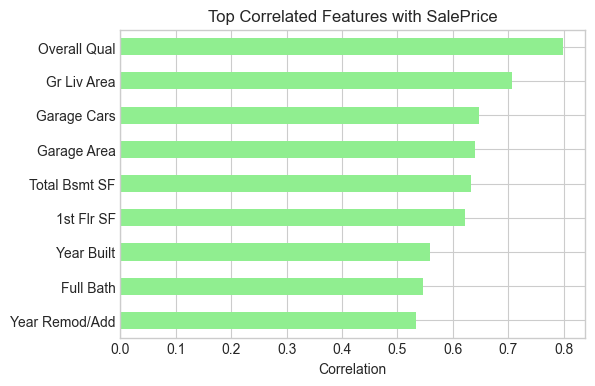

In [6]:
corr = df.corr(numeric_only=True)[target].sort_values(ascending=False)
print("\nTop 10 Correlated Features with SalePrice:")
print(corr.head(10))

plt.figure(figsize=(6,4))
corr.head(10).drop(target).plot(kind='barh', color='lightgreen')
plt.title("Top Correlated Features with SalePrice")
plt.xlabel("Correlation")
plt.gca().invert_yaxis()
plt.show()

/var/folders/xq/xwyvblmd3_94y10k_c_ggfq00000gn/T/ipykernel_87884/1812571865.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Overall Qual', y='SalePrice', data=df, palette='Blues')


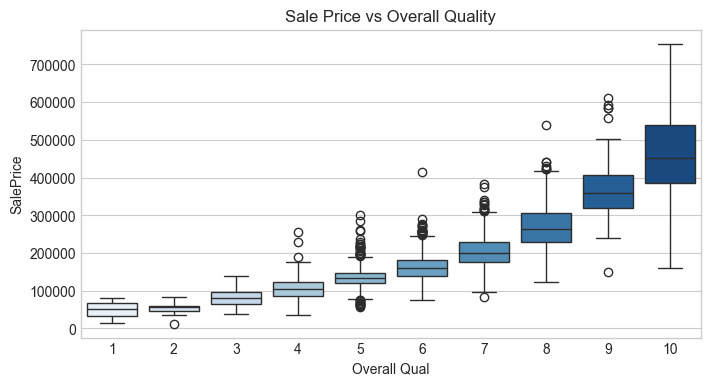

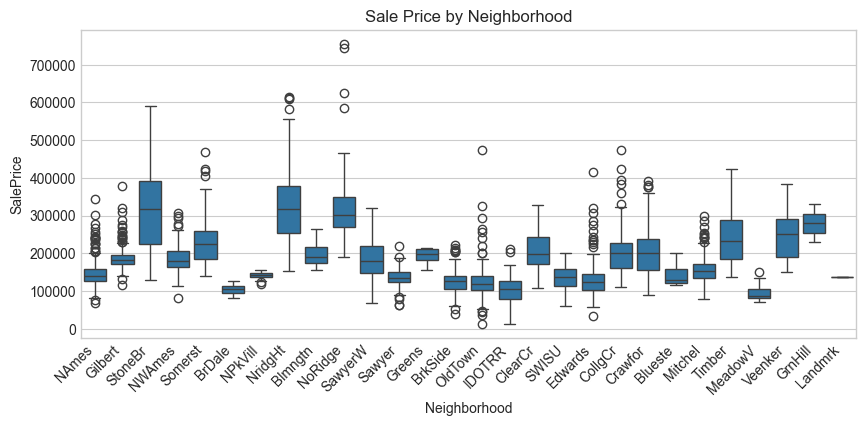

In [10]:
plt.figure(figsize=(8,4))
sns.boxplot(x='Overall Qual', y='SalePrice', data=df, palette='Blues')
plt.title("Sale Price vs Overall Quality")
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(x='Neighborhood', y='SalePrice', data=df)
plt.xticks(rotation=45, ha='right')
plt.title("Sale Price by Neighborhood")
plt.show()

In [11]:
print("\nEDA Summary:")
print(f"- Total records: {df.shape[0]} | Total features: {df.shape[1]}")
print(f"- {len(categorical_cols)} categorical, {len(numeric_cols)} numeric features.")
print(f"- {missing.count()} features contain missing values.")
print(f"- SalePrice is right-skewed ({round(df[target].skew(),2)}).")
print("- Strongly correlated features include OverallQual, GrLivArea, and GarageCars.")


EDA Summary:
- Total records: 2930 | Total features: 82
- 43 categorical, 39 numeric features.
- 27 features contain missing values.
- SalePrice is right-skewed (1.74).
- Strongly correlated features include OverallQual, GrLivArea, and GarageCars.
